In [1]:
# !pip install librosa # https://librosa.org/doc/latest/index.html
import numpy as np
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Wave file
WAV_FILE = 'shortpassagea_CT.wav'
# The number of melodies to extract (Frequency resolution for the Mel spectrogram)
# Increase this to get a better resolution in the frequency domain
N_MELS = 256 #128
# Mel frame size; I will be chunking the audio into 1024-sample frames at a time
MEL_SPEC_FRAME_SIZE = 1024

In [3]:
def spectrogram(wavfile_path, chunk_seconds=None, plot=False, log_plot=False):
    """Function to extract spectrogram from wav file
    
    Args:
        wavfile_path (str): path to wav file
        chunk_seconds (int): number of seconds to extract from wav file
        plot (bool): whether to plot the spectrogram
        log_plot (bool): whether to plot the spectrogram in log scale
        
    Returns:
        spectrogram (np.array): spectrogram of wav file
    """
    # Using librosa to load the wav file
    # sig is the audio signal, fs is  the sampling frequency, here we are enforcing it 16kHz
    sig, fs = librosa.load(wavfile_path, sr=16000)

    # Pre-processing
    # normalize values between [-1,1]
    sig /= np.max(np.abs(sig), axis=0)

    # For chunk size, we can either use the entire audio file or a few seconds of it
    if not chunk_seconds:
        chunk_samples = len(sig)
    else:
        # get first few seconds
        chunk_samples = fs * chunk_seconds

    # Extracting the spectrogram through short-time Fourier transform (STFT) using librosa
    spectrogram = librosa.stft(sig[0:0 + chunk_samples])
    # Converting the raw amplitude rsults to decibels (log scale)
    spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref=1.0)

    # # normalize to [0,1]
    # scaler = MinMaxScaler(feature_range=(0, 1), copy=False, clip=True)
    # scaler.fit_transform(spectrogram)

    # If statement to plot the spectorgram
    if plot:
        plt.figure(figsize=(20, 8))
        plt.xlabel('Time')
        plt.ylabel('Mel-Frequency')

        scale='linear'
        if log_plot:
            scale='log'

        librosa.display.specshow(spectrogram,
                                 y_axis=scale,
                                 fmax=fs / 2,
                                 sr=fs, # sampling rate is the frequency at which the samples are taken from the signal
                                 hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                 x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Linear Spectrogram')
        plt.tight_layout()
        plt.show()

    return spectrogram

In [4]:
def mel_spectrogram(wavfile_path, chunk_seconds=None, plot=False):
    """Function to extract mel spectrogram from wav file

    Args:
        wavfile_path (str): path to wav file
        chunk_seconds (int): number of seconds to extract from wav file
        plot (bool): whether to plot the spectrogram

    Returns:
        melspec (np.array): mel spectrogram of wav file
    """
    # Read from wav file
    sig, fs = librosa.load(wavfile_path, sr=16000)
    # mel_spec_frame_size = int(fs * 0.03)

    # normalize between [-1,1]
    sig /= np.max(np.abs(sig), axis=0)

    # For chunk size, we can either use a fixed number of samples or a fixed number of seconds
    if not chunk_seconds:
        chunk_samples = len(sig)
    else:
        # get first few seconds
        chunk_samples = fs * chunk_seconds

    # Using librosa to extract the mel spectrogram, but the parameters are the same
    # It takes tha additional parameter n_mels, which is the number of mel bins/frequencies
    melspec = librosa.feature.melspectrogram(y=sig[0:0 + chunk_samples],
                                             sr=fs,
                                             center=True,
                                             n_fft=MEL_SPEC_FRAME_SIZE,
                                             hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                             n_mels=N_MELS)
    melspec = librosa.power_to_db(melspec, ref=1.0)

    # # normalize to [0,1]
    # scaler = MinMaxScaler(feature_range=(0, 1), copy=False, clip=True)
    # scaler.fit_transform(melspec)

    if plot:
        plt.figure(figsize=(20, 8))
        plt.xlabel('Time')
        plt.ylabel('Mel-Frequency')
        librosa.display.specshow(melspec,
                                 y_axis='mel',
                                 fmax=fs / 2,
                                 sr=fs,
                                 hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                 x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        plt.tight_layout()
        plt.show()

    return melspec, fs

In [5]:
def mfcc_coefficients(wavfile_path, filters=20,plot=False):
    """Function to extract MFCC coefficients from wav file
        (Older version of the mel spectrogram, where you need to decide the number of filters)
    Args:
        wavfile_path (str): path to wav file
        filters (int): number of filters to use
        plot (bool): whether to plot the spectrogram

    Returns:
        mfccs (np.array): MFCC coefficients of wav file
    """
    # Retrieve the mel spectrogram
    melspec, fs = mel_spectrogram(wavfile_path=wavfile_path, chunk_seconds=5, plot=False)
    mfccs = librosa.feature.mfcc(S=melspec,n_mfcc=filters)

    if plot:
        plt.figure(figsize=(20, 8))
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficient')
        # Using librosa to display the MFCC coefficients
        librosa.display.specshow(mfccs,
                                 fmax=fs / 2,
                                 sr=fs,
                                 hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                 x_axis='time')
        # plt.colorbar(format='%+2.0f dB')
        plt.title('MFCC Coefficients')
        plt.tight_layout()
        plt.show()

    return mfccs

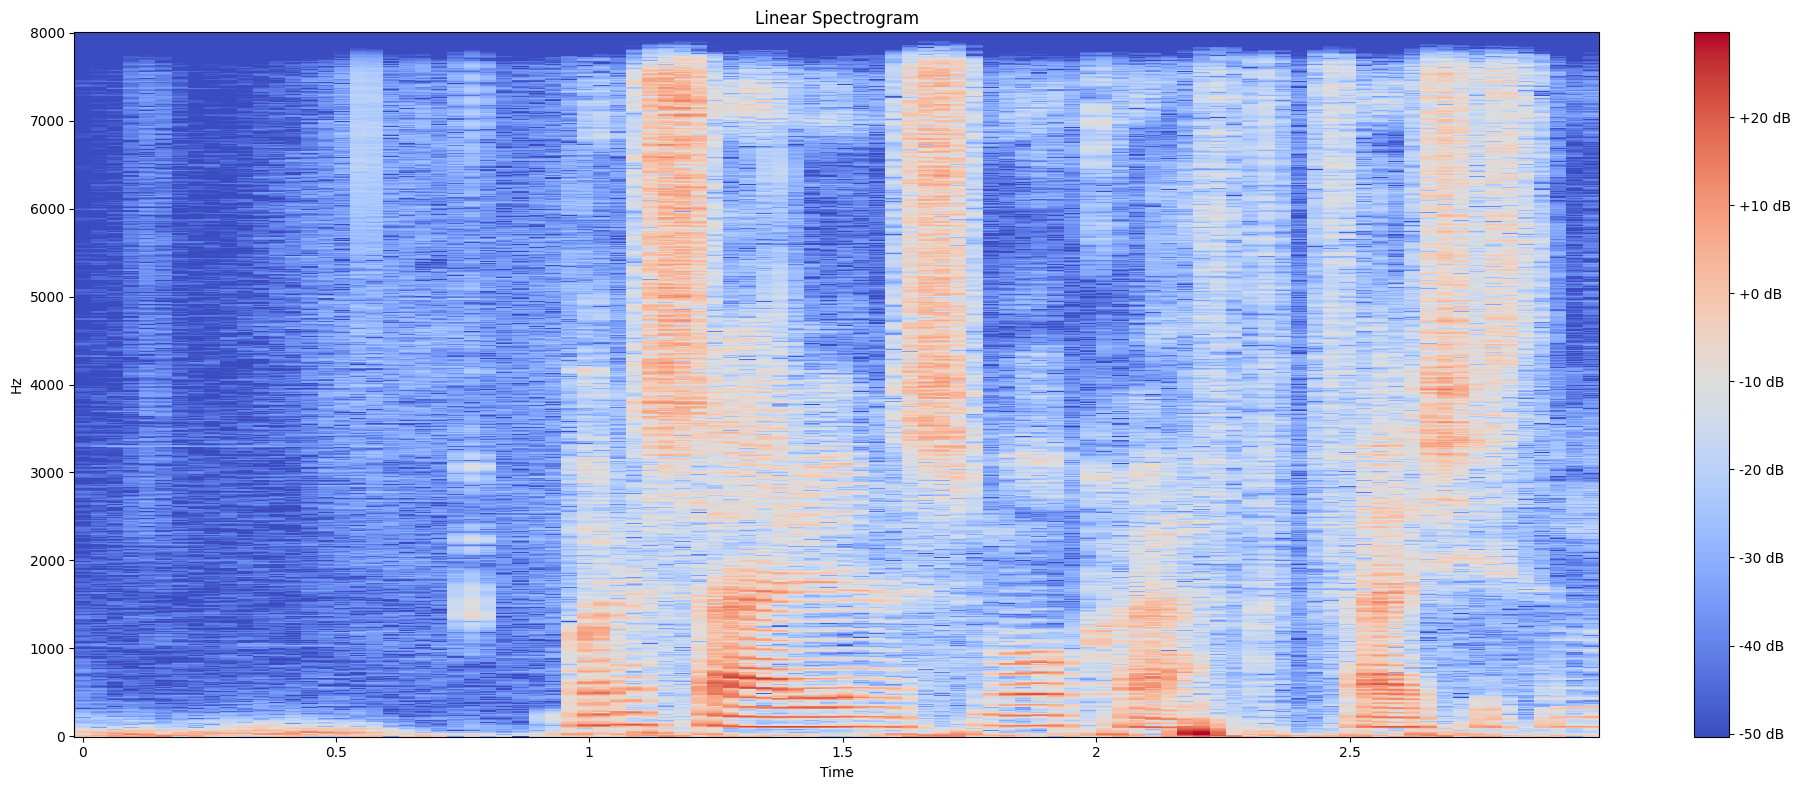

In [6]:
# Plotting the spectogram for the first 3 seconds of the audio
spectrogram = spectrogram(wavfile_path=WAV_FILE, chunk_seconds=3, plot=True, log_plot=False)

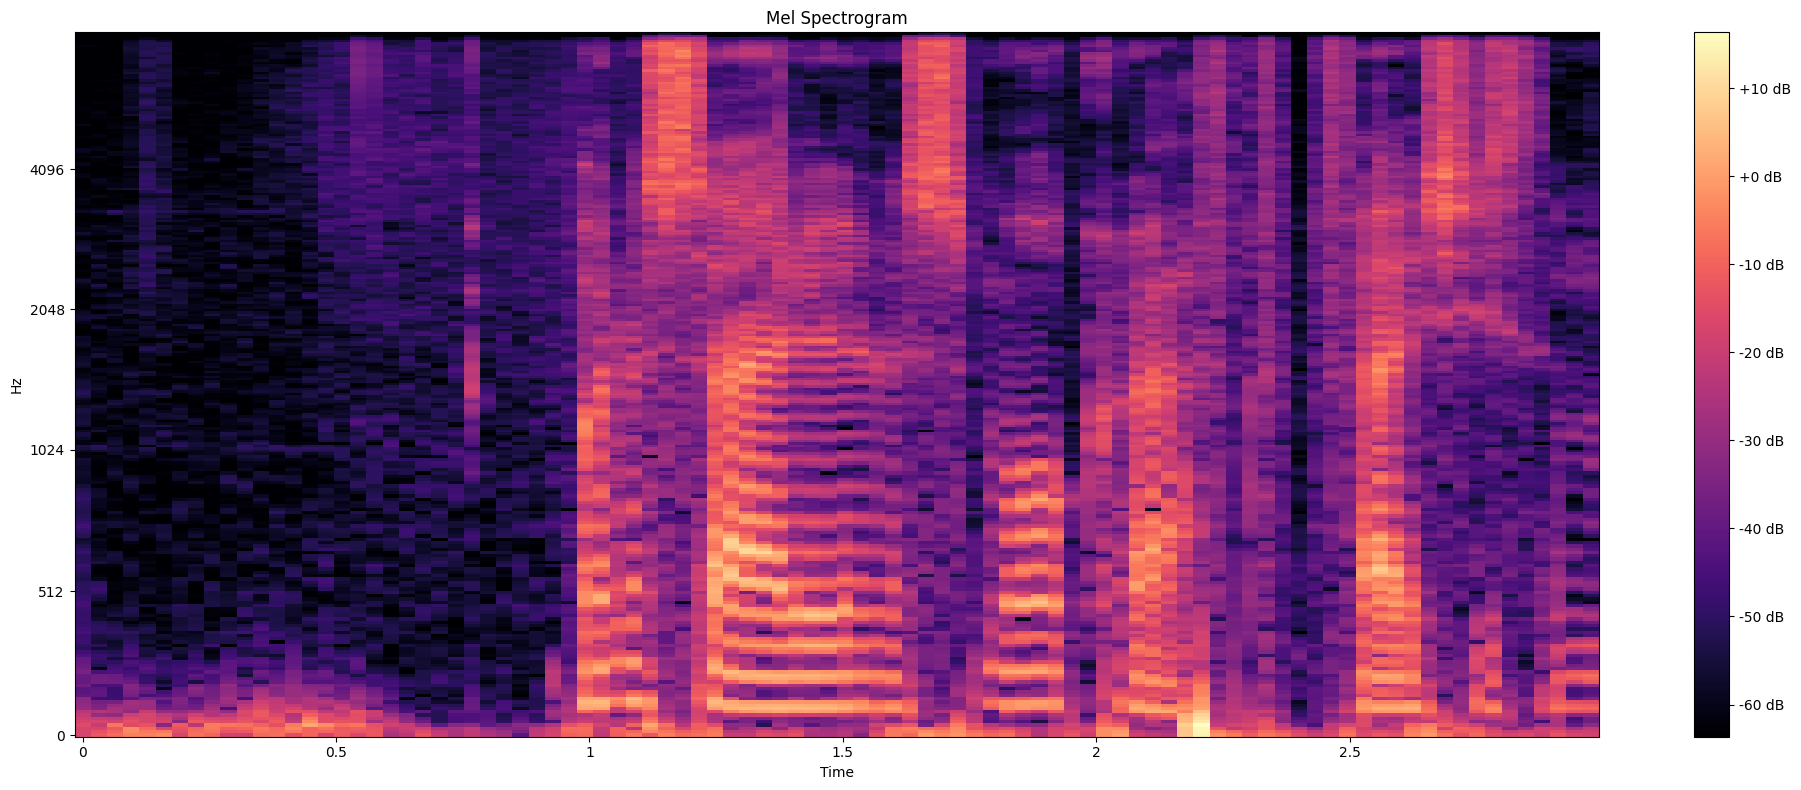

In [7]:
# Plotting the mel spectrogram for the first 3 seconds of the audio
melSpectrogram,fs = mel_spectrogram(wavfile_path=WAV_FILE, chunk_seconds=3, plot=True)

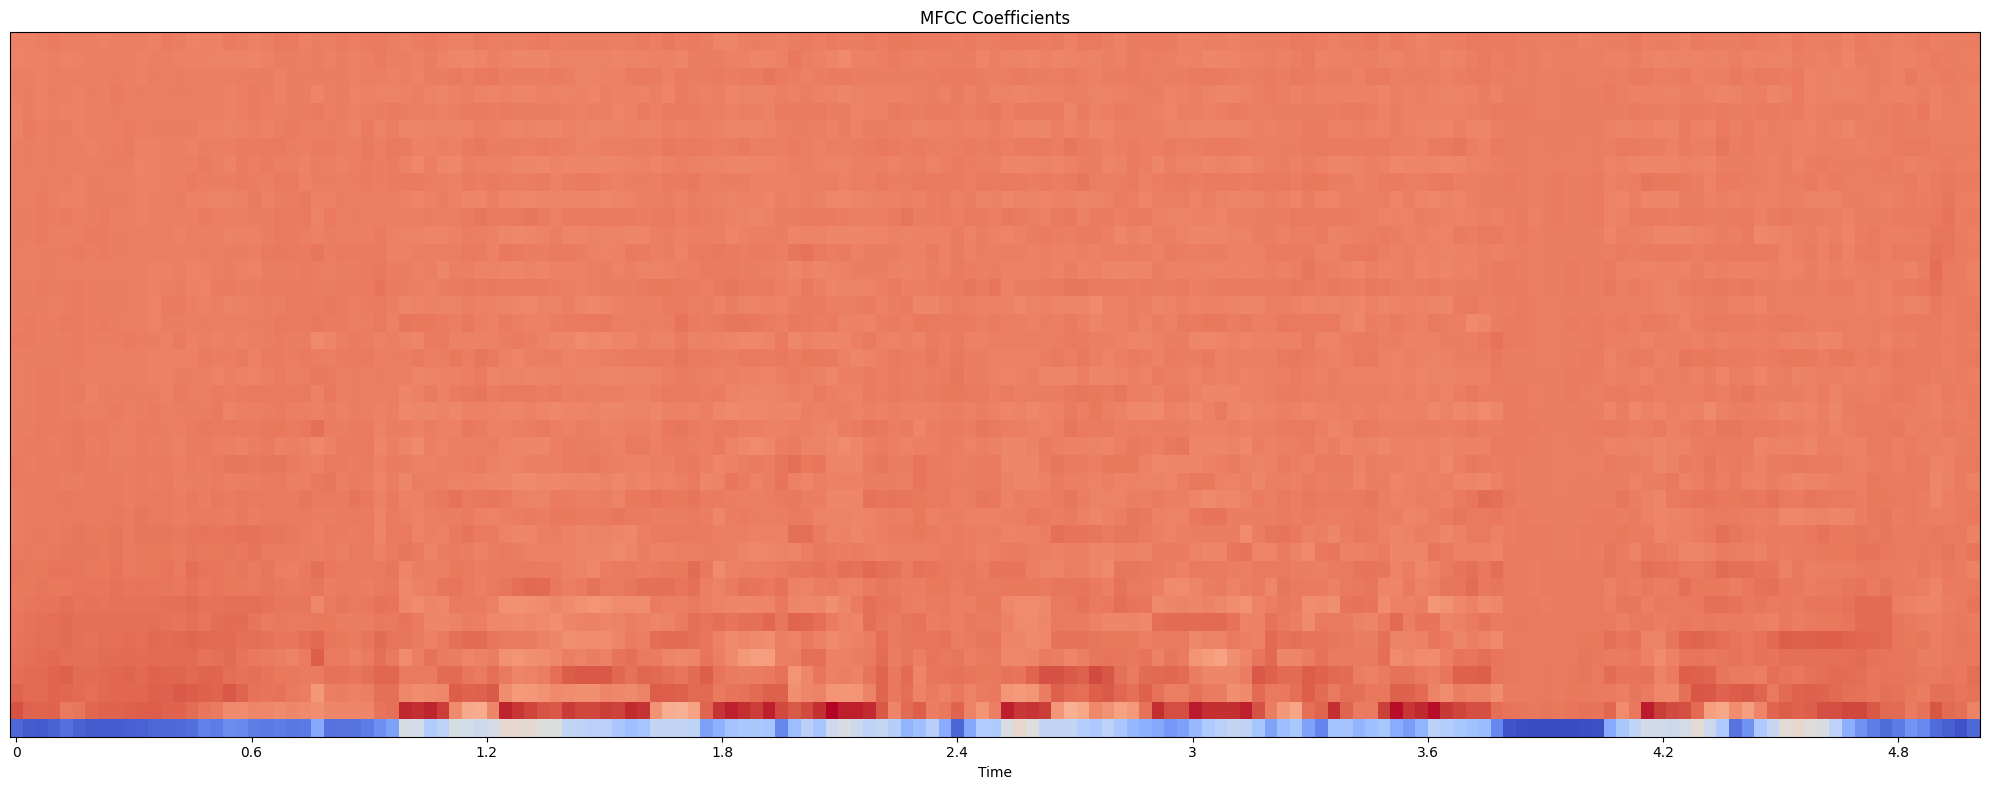

In [8]:
# Plotting the MFCC coefficients for the first 3 seconds of the audio, with 40 filters
# Note that the number of filters is the number of mel frequencies, and all the information which is compressed in 40 values
mfccs = mfcc_coefficients(wavfile_path=WAV_FILE, filters=40, plot=True)